In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawMLPChromosome


low, high = RawMLPChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 2, 3, 3, 1, 1, 6, 3]))

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas_params import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = VertebralDataset
params = NasParams(
    epochs=15,
    patience=5,
    amount_of_evaluations=3,
    population_size=50,
    population_offspring_count=20,
    algorithm_generations=10,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(162.0, np.float64(2160.0))

In [4]:
plow = problem.get_nn_params(RawMLPChromosome(low).parse())
phigh = problem.get_nn_params(RawMLPChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(162.0, np.float64(2160.0))

In [5]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

if params.population_store_file is not None:
    params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded successfully


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        1 |      1 |             - |             -
     2 |       21 |      1 |  0.0483870968 |         ideal
     3 |       41 |      1 |  0.000000E+00 |             f
     4 |       61 |      1 |  0.000000E+00 |             f
     5 |       81 |      1 |  0.000000E+00 |             f
     6 |      101 |      1 |  0.0161290323 |         ideal
     7 |      121 |      1 |  0.000000E+00 |             f
     8 |      141 |      1 |  0.000000E+00 |             f
     9 |      161 |      2 |  0.000000E+00 |             f
    10 |      181 |      2 |  0.000000E+00 |             f
Solutions: [[2 0 6 2 8 0 8 0 0 1 3 0 1 6 0]
 [2 0 8 4 7 2 8 2 0 1 3 0 1 6 0]]
Objectives: [[-0.90322581  0.        ]
 [-0.90322581  0.        ]]


In [6]:
df = problem.result_as_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,90.322581,162.0,"{'layers': [{'height': 6, 'weight_qmode': Weig...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[2, 0, 6, 2, 8, 0, 8, 0, 0, 1, 3, 0, 1, 6, 0]"
1,90.322581,162.0,"{'layers': [{'height': 6, 'weight_qmode': Weig...",{'DatasetCls': <class 'src.datasets.vertebral_...,"[2, 0, 8, 4, 7, 2, 8, 2, 0, 1, 3, 0, 1, 6, 0]"


In [7]:
from pprint import pprint

ch = RawMLPChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            weight_qmode=<WeightQuantMode.NBITS: 'nbits'>,
                                            weight_bitwidth=3),
                              FCLayerParams(height=3,
                                            weight_qmode=<WeightQuantMode.NONE: 'none'>,
                                            weight_bitwidth=32)],
                      activation=ActivationParams(activation=<ActivationModule.BINARIZE: 'binary'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                                                  reste_o=4.0,
                                                  reste_threshold=1.5),
                      qmode=<QMode.DET: 'det'>,
                      dropout_rate=0.0),
          train=NNTrainParams(DatasetCls=<class 'src.datasets.vertebral_dataset.VertebralDataset'>,
                              train_loader=<torch.utils.data.dataloader.Dat

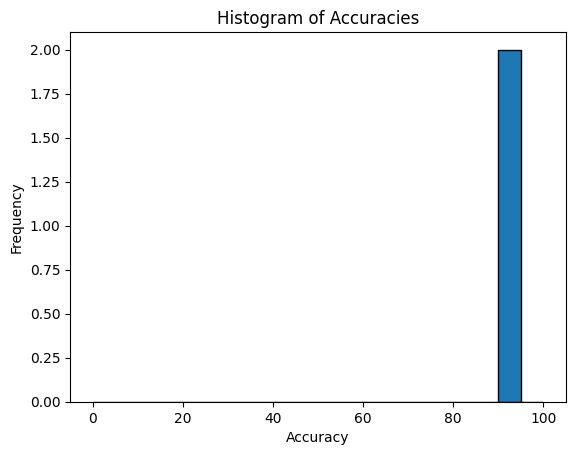

In [8]:
fig = hist_accuracies(df["Accuracy"])

/home/nur/Projects/vut-ip1-nn-quantization/src/nas/plot.py:46: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(


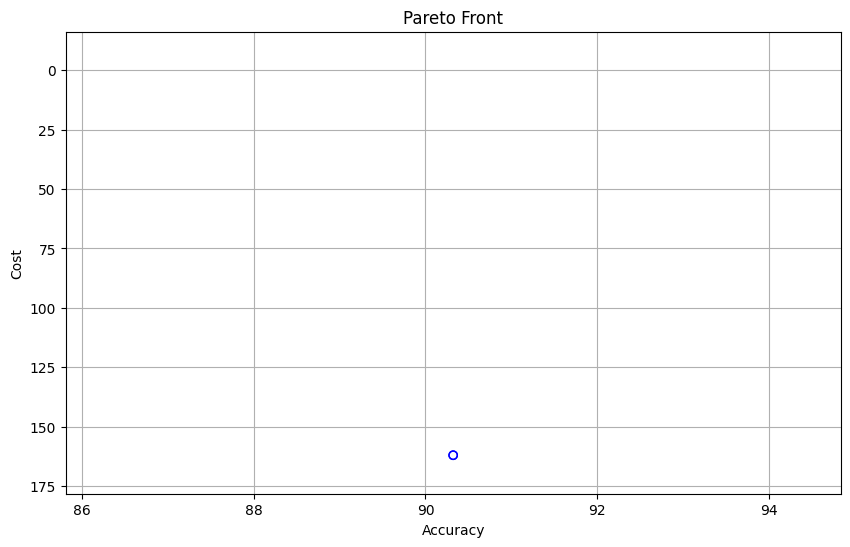

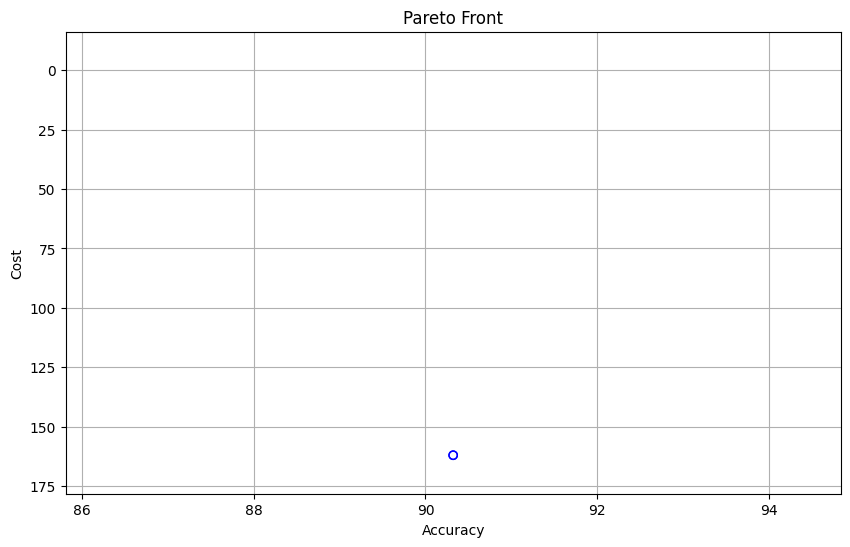

In [9]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])